In [1]:
import numpy as np
import os
import pandas as pd
import datetime as dt

## Ingesta de datos

IMPORTAMOS DATOS DE TRMS e IPP

In [2]:
"""Fuente: DANE
    Consulta: 01/09/2024"""
df_TRM =pd.read_csv("TRM.csv",delimiter=";")

# Convertir a formato de fecha
df_TRM['Fecha'] = pd.to_datetime(df_TRM['Fecha'])
df_TRM = df_TRM.groupby(df_TRM['Fecha'].dt.to_period('M')).max().drop(columns=['Fecha'])
df_TRM = df_TRM.reset_index()
df_TRM['TRM'] = df_TRM['TRM'].astype('float64')
#Importamos datos IPP
df_ipp = pd.read_csv("IPP_MARZO_2023.csv",delimiter=";")

#agruparmos la ipp por mes
df_ipp['Fecha'] = pd.to_datetime(df_ipp['Fecha'])
df_ipp = df_ipp.groupby(df_ipp['Fecha'].dt.to_period('M')).mean().reset_index()

Cargamos los datos de demanda, precio y embalses

In [3]:
!pip install pydataxm
from pydataxm import *

objetoAPI = pydataxm.ReadDB()

df_precio = objetoAPI.request_data(
                                    'PrecBolsNaciTX1',
                                    'Sistema',
                                    dt.date(2015, 1, 1),
                                    dt.date(2024, 8, 1))
df_demanda = objetoAPI.request_data(
                                    'DemaReal',
                                    'Sistema',
                                    dt.date(2015, 1, 1),
                                    dt.date(2024, 8, 1))

# Seleccionar las columnas que comienzan con 'Values_Hour'
columnas_a_promediar = df_demanda.filter(regex='^Values_Hour')

# Calcular el promedio por fila y agregar como nueva columna
df_demanda['demanda diaria'] = columnas_a_promediar.max(axis=1)

# Seleccionar las columnas que comienzan con 'Values_Hour'
columnas_a_promediar = df_precio.filter(regex='^Values_Hour')

# Calcular el promedio por fila y agregar como nueva columna
df_precio['precio maximo'] = columnas_a_promediar.mean(axis=1)

# Unir los DataFrames por la columna 'Date', seleccionando solo las columnas especificadas
df_demanda_precio = pd.merge(df_demanda, df_precio, 
                  left_on='Date', right_on='Date',
                  how='inner')
df_demanda_precio= df_demanda_precio[['Date', 'demanda diaria', 'precio maximo']]


In [4]:
"""Fuente: XM
    Consulta: 01/09/2024"""
#Cargamos datos embalse
#embalse
df_embalse = objetoAPI.request_data(
                                    'PorcVoluUtilDiar',
                                    'Sistema',
                                    dt.date(2014, 1, 1),
                                    dt.date(2024, 8, 1))
df_embalse = df_embalse.drop("Id",axis=1)


Aportes_vs_historico = objetoAPI.request_data(
                                    'PorcApor',
                                    'Sistema',
                                    dt.date(2014, 1, 1),
                                    dt.date(2024, 8, 1))

#cambiamos el tipo de fecha
df_embalse["Fecha"] = pd.to_datetime(df_embalse['Date'])
df_embalse = df_embalse.drop("Date",axis=1)

#Agregamos la variable de Aportes_vs_historico es 	[Aportes Caudal / Media Histórica]*100
df_embalse["Aportes_vs_historico"] = Aportes_vs_historico['Value']
#Definimos la variable que usaremos
df_embalse.rename(columns={'Value': 'Niveles_embalse'}, inplace=True)

#agrupamos los datos por fecha (mes y anno)
df_embalse = df_embalse.groupby(df_embalse['Fecha'].dt.to_period('M')).mean()

df_embalse = df_embalse.reset_index()


Unimos todos los indicadores en una sola tabla como index se utiliza la fecha

In [5]:
indicadores = pd.merge(df_ipp, df_TRM, on='Fecha')
indicadores = pd.merge(indicadores, df_embalse, on='Fecha')

indicadores

,Fecha,IPP,TRM,Niveles_embalse,Aportes_vs_historico
0,2014-01,94.68,1960.41,0.661708,0.968994
1,2014-02,95.83,2040.51,0.561903,1.103430
2,2014-03,97.47,2022.19,0.518162,1.144305
3,2014-04,97.89,1939.27,0.442087,0.793991
4,2014-05,97.77,1915.46,0.476622,0.764110
...,...,...,...,...,...
122,2024-03,177.63,3908.67,0.367905,0.455753
123,2024-04,178.18,3866.12,0.306643,0.596821
124,2024-05,177.37,3865.09,0.380780,0.977904
125,2024-06,179.00,4054.56,0.514640,1.168736


In [6]:
#cambiamos a tipo data el dataframe 
df_demanda_precio['Date'] = pd.to_datetime(df_demanda_precio['Date'])

# Crea una nueva columna 'Mes_Año' que contenga solo el mes y el año
df_demanda_precio['Mes_Año'] = df_demanda_precio['Date'].dt.to_period('M')

#Dado que el precio de los contratos estan indexados, análizamos el precio de bolsa considerando el IPP
df_demanda_precio_ipp = pd.merge(df_demanda_precio, df_ipp, left_on='Mes_Año', right_on='Fecha', how='left')
df_demanda_precio_ipp["precio_ipp"] = df_demanda_precio_ipp["precio maximo"]/df_demanda_precio_ipp["IPP"]

Cargamos y procesamos los datos de contratos

In [7]:
#Importamos los datos de los contratos de Sicep
#precio de contratos
df_contratos = pd.read_excel("Dats_Sicep_agosto_2024.xls")
df_contratos = df_contratos.fillna(0)

#Realizamos la limpieza de los que no fueron adjudicados
df_contratos_filtrado = df_contratos[df_contratos["Precio promedio ponderado adjudicado ($/KWh)"]!=0]

#df_contratos_filtrado = df_contratos_filtrado[df_contratos_filtrado["Precio promedio ponderado adjudicado ($/KWh)"].notna()]

## Limpieza de datos

In [8]:
#Cambiamos columnas a fecha
df_contratos_filtrado["FechaPublicacionAviso"] = pd.to_datetime(df_contratos_filtrado['FechaPublicacionAviso'], dayfirst=True)
df_contratos_filtrado["FechaPliegosParaConsulta"] = pd.to_datetime(df_contratos_filtrado['FechaPliegosParaConsulta'], dayfirst=True)
df_contratos_filtrado["FechaPliegosDefinitivos"] = pd.to_datetime(df_contratos_filtrado['FechaPliegosDefinitivos'], dayfirst=True)
df_contratos_filtrado["FechaLimiteRecepcionOfertas"] = pd.to_datetime(df_contratos_filtrado['FechaLimiteRecepcionOfertas'], dayfirst=True)
df_contratos_filtrado["AudienciaPublica"] = pd.to_datetime(df_contratos_filtrado['AudienciaPublica'], dayfirst=True)
df_contratos_filtrado["FechaCierreConvocatoria"] = pd.to_datetime(df_contratos_filtrado['FechaCierreConvocatoria'], dayfirst=True)
df_contratos_filtrado["periodo_inicio"] = pd.to_datetime(df_contratos_filtrado['periodo_inicio'], dayfirst=True)
df_contratos_filtrado["periodo_fin"] = pd.to_datetime(df_contratos_filtrado['periodo_fin'], dayfirst=True)

#Creamos una columna para ano y mes
df_contratos_filtrado['Fecha'] = df_contratos_filtrado['FechaLimiteRecepcionOfertas'].dt.strftime('%Y-%m')

C:\Users\DELLPHOTO\AppData\Local\Temp\ipykernel_33584\2181399209.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_contratos_filtrado["FechaPublicacionAviso"] = pd.to_datetime(df_contratos_filtrado['FechaPublicacionAviso'], dayfirst=True)
C:\Users\DELLPHOTO\AppData\Local\Temp\ipykernel_33584\2181399209.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_contratos_filtrado["FechaPliegosParaConsulta"] = pd.to_datetime(df_contratos_filtrado['FechaPliegosParaConsulta'], dayfirst=True)
C:\Users\DELLPHOTO

Calculamos los dias del contrato

In [9]:
#Duracion del contrato
df_contratos_filtrado = df_contratos_filtrado.rename(columns={"DuracionDias": "dias_contrato"})
#Dias de diferencia entre el iniciio de la obligaciones y la AudienciaPublica
df_contratos_filtrado["dias_antes_inicio"]=(df_contratos_filtrado.periodo_inicio-df_contratos_filtrado.FechaLimiteRecepcionOfertas).dt.days

Unimos los datos de indicadores y resultados

Agregamos los indicadores anteriores

In [10]:
#Agregamos indicadores
indicadores['Fecha'] = indicadores['Fecha'].astype(str)
result = df_contratos_filtrado.merge(indicadores, on='Fecha', how='inner')
result = result[result['dias_antes_inicio']> 0 ]
result.reset_index(inplace=True, drop=True)

Agregamos la demanda promedio de los dias entre la publicacion y la asignacion, junto con el precio maximo de bolsa, dividido entre el ipp de ese mes

In [11]:
def sumar_precio_ipp(df_fncer, df_demanda_precio_ipp):
    # Convierte las columnas de fecha a tipo datetime
    df_fncer['FechaPliegosDefinitivos'] = pd.to_datetime(df_fncer['FechaPliegosDefinitivos'], dayfirst=True)
    df_fncer['FechaLimiteRecepcionOfertas'] = pd.to_datetime(df_fncer['FechaLimiteRecepcionOfertas'], dayfirst=True)
    df_demanda_precio_ipp['Date'] = pd.to_datetime(df_demanda_precio_ipp['Date'], dayfirst=True)
    
    df_sum = pd.DataFrame(columns=['FechaPliegosDefinitivos', 'FechaLimiteRecepcionOfertas', 'max_precio_ipp', 'mean_demanda_diaria','precio_maximo'])
    
    # Itera sobre las filas de df_fncer
    for _, row in df_fncer.iterrows():
        fecha_inicio = row['FechaPliegosDefinitivos']
        fecha_fin = row['FechaLimiteRecepcionOfertas']
        
        # Filtra las filas de df_demanda_precio_ipp que cumplan con la condición de fecha
        mask = (df_demanda_precio_ipp['Date'] >= fecha_inicio) & (df_demanda_precio_ipp['Date'] <= fecha_fin)
        
        df_filtered = df_demanda_precio_ipp.loc[mask]
        # Suma los valores de 'precio_ipp' y agrega una fila al DataFrame de resultado
        max_precio_ipp = df_filtered['precio_ipp'].max()
        mean_demanda_diaria = df_filtered['demanda diaria'].mean()
        precio_maximo = df_filtered['precio maximo'].max()
        df_sum = df_sum.append({'FechaPliegosDefinitivos': fecha_inicio, 'FechaLimiteRecepcionOfertas': fecha_fin,
                                 'max_precio_ipp': max_precio_ipp, 'mean_demanda_diaria':mean_demanda_diaria,
                                 'precio_maximo':precio_maximo}, ignore_index=True)
    
    return df_sum



df_sum_precio_ipp = sumar_precio_ipp(result, df_demanda_precio_ipp)

#Agregamos los resultados a la base de datos principal
result['max_precio_bolsa_ipp'] = pd.to_numeric(df_sum_precio_ipp.max_precio_ipp, errors='coerce')
result['promedio_demanda_diaria'] = pd.to_numeric(df_sum_precio_ipp.mean_demanda_diaria, errors='coerce')
result['precio_maximo_bolsa'] = pd.to_numeric(df_sum_precio_ipp.precio_maximo, errors='coerce')


In [12]:
print(result.shape)

(542, 38)


In [13]:
result.to_excel("datos_finales.xlsx")

Creamos el df con las columnas que necesitamos

In [14]:
indicadores.columns

Index(['Fecha', 'IPP', 'TRM', 'Niveles_embalse', 'Aportes_vs_historico'], dtype='object')

In [15]:
df = result[["Cantidad de energía demandada GWh","Cantidad de energía adjudicada GWh","Precio promedio ponderado adjudicado ($/KWh)"
                , 'Niveles_embalse', 'Aportes_vs_historico', 'IPP', 'TRM',"dias_contrato","dias_antes_inicio","Niveles_embalse",'max_precio_bolsa_ipp','precio_maximo_bolsa','promedio_demanda_diaria']]


df["productos"] = result.Productos
df["descripcion"] = result.descripcion
df["energia_por_dia"] = result["Cantidad de energía adjudicada GWh"]/result["dias_contrato"]



C:\Users\DELLPHOTO\AppData\Local\Temp\ipykernel_33584\3131343787.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["productos"] = result.Productos
C:\Users\DELLPHOTO\AppData\Local\Temp\ipykernel_33584\3131343787.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["descripcion"] = result.descripcion
C:\Users\DELLPHOTO\AppData\Local\Temp\ipykernel_33584\3131343787.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

In [16]:
#Eliminamos columnas con valores nulos
print(df.shape)
df=df.dropna()
df.shape

(542, 16)


(542, 16)

PCA

In [17]:
df.columns

Index(['Cantidad de energía demandada GWh',
       'Cantidad de energía adjudicada GWh',
       'Precio promedio ponderado adjudicado ($/KWh)', 'Niveles_embalse',
       'Aportes_vs_historico', 'IPP', 'TRM', 'dias_contrato',
       'dias_antes_inicio', 'Niveles_embalse', 'max_precio_bolsa_ipp',
       'precio_maximo_bolsa', 'promedio_demanda_diaria', 'productos',
       'descripcion', 'energia_por_dia'],
      dtype='object')

In [18]:
df["PRECIO_ipp"] = df["Precio promedio ponderado adjudicado ($/KWh)"]/df["IPP"]

In [19]:
df.to_excel("datos_finales.xlsx")

In [20]:
df.dtypes

Cantidad de energía demandada GWh               float64
Cantidad de energía adjudicada GWh              float64
Precio promedio ponderado adjudicado ($/KWh)    float64
Niveles_embalse                                 float64
Aportes_vs_historico                            float64
IPP                                             float64
TRM                                             float64
dias_contrato                                     int64
dias_antes_inicio                                 int64
Niveles_embalse                                 float64
max_precio_bolsa_ipp                            float64
precio_maximo_bolsa                             float64
promedio_demanda_diaria                         float64
productos                                        object
descripcion                                      object
energia_por_dia                                 float64
PRECIO_ipp                                      float64
dtype: object

In [21]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
# Normalizar los datos
scaler = StandardScaler()
df_scalar = df.drop(columns=['productos', 'descripcion'])
df_norm = scaler.fit_transform(df_scalar)
# Crear un objeto PCA con el número de componentes deseadas
pca = PCA(n_components=2)

# Aplicar PCA a los datos numéricos del dataframe
pca_result = pca.fit_transform(df_norm)

# Crear un nuevo dataframe con los resultados de PCA
df_pca = pd.DataFrame(data=pca_result)

# Obtener la varianza explicada por cada componente
variance_explained = pca.explained_variance_ratio_
print("Varianza explicada por PC1: ", variance_explained.sum())

Varianza explicada por PC1:  0.4940675687859096


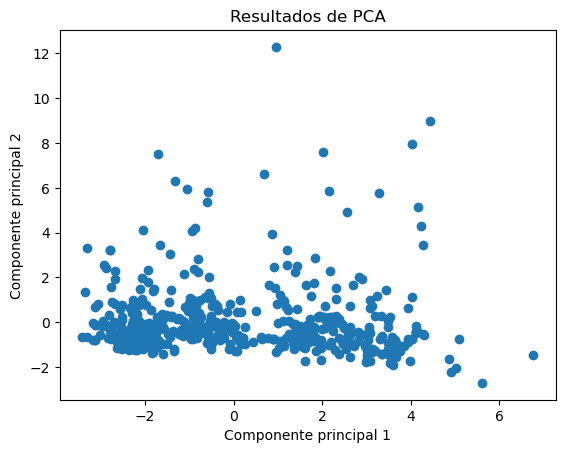

In [22]:
import matplotlib.pyplot as plt

plt.scatter(pca_result[:, 0], pca_result[:, 1])
plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
plt.title('Resultados de PCA')
plt.show()


In [23]:
from sklearn.cluster import DBSCAN

# Definir el modelo y ajustarlo a los datos
dbscan = DBSCAN(eps=1.5, min_samples=4)
dbscan.fit(df_pca)

# Obtener las etiquetas de cada punto
labels = dbscan.labels_

# Imprimir el número de clusters encontrados
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print("Número de clusters encontrados:", n_clusters)
sum(labels<0)

Número de clusters encontrados: 2


8

## Analisis exploratorio de las variables

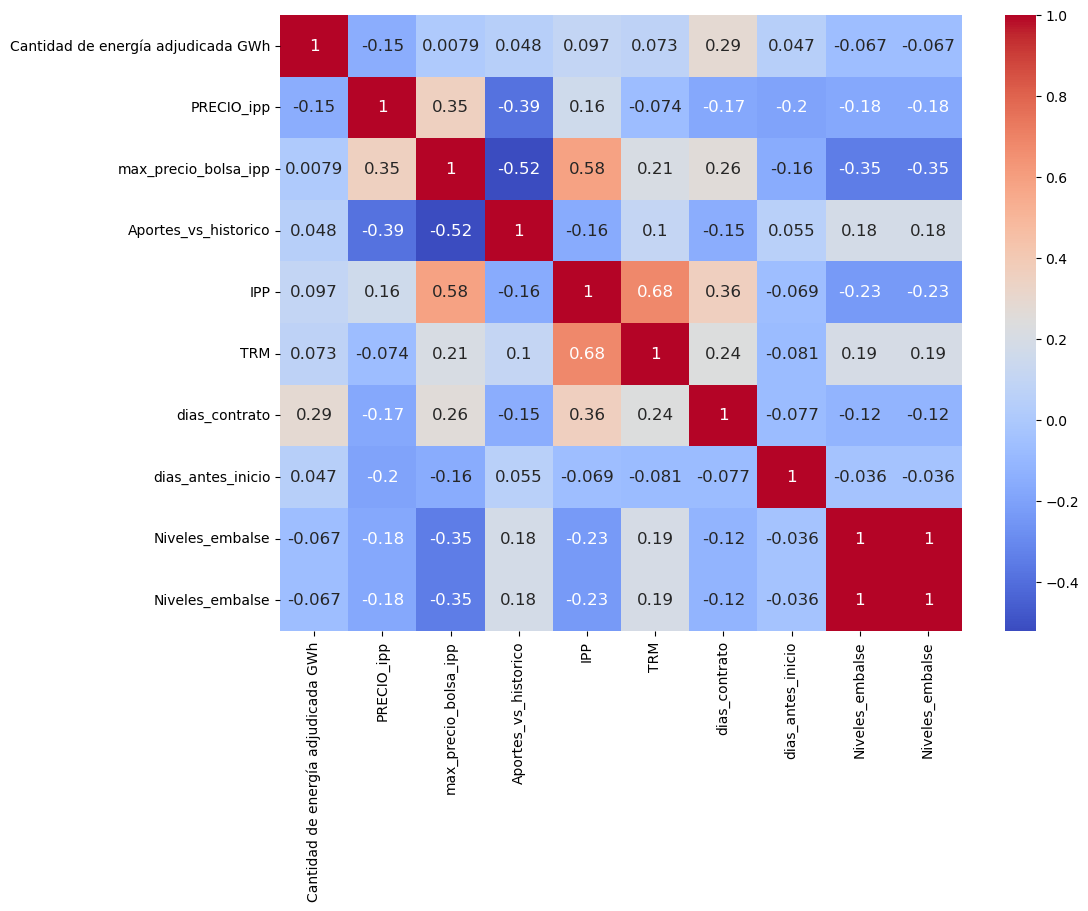

In [24]:
import seaborn as sns
df_correlacion = df[["Cantidad de energía adjudicada GWh","PRECIO_ipp", 'max_precio_bolsa_ipp',
                'Aportes_vs_historico', 'IPP', 'TRM',"dias_contrato","dias_antes_inicio","Niveles_embalse"]]

# Calcula la matriz de correlación
corr_matrix = df_correlacion.corr()
# Crea el mapa de calor de las correlaciones
fig, ax = plt.subplots(figsize=(11,8))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=True, fmt='.2g', annot_kws={"size": 12})
plt.show()

In [25]:
# Calcula las estadísticas descriptivas del dataframe
corr_stats = df_correlacion.describe()

# Muestra el resultado
print(corr_stats)

       Cantidad de energía adjudicada GWh  PRECIO_ipp  max_precio_bolsa_ipp  \
count                          542.000000  542.000000            542.000000   
mean                           391.317712    1.674519              2.933143   
std                            797.620451    0.240323              1.857594   
min                              0.050000    1.107507              0.643004   
25%                             33.302500    1.520356              1.471731   
50%                            102.855000    1.644440              2.182565   
75%                            365.235000    1.780564              4.334080   
max                           9106.000000    3.882346              8.306579   

       Aportes_vs_historico         IPP          TRM  dias_contrato  \
count            542.000000  542.000000   542.000000     542.000000   
mean               0.993843  158.225277  4000.274317    2808.300738   
std                0.284706   21.155973   342.510695    1705.361646   
min 

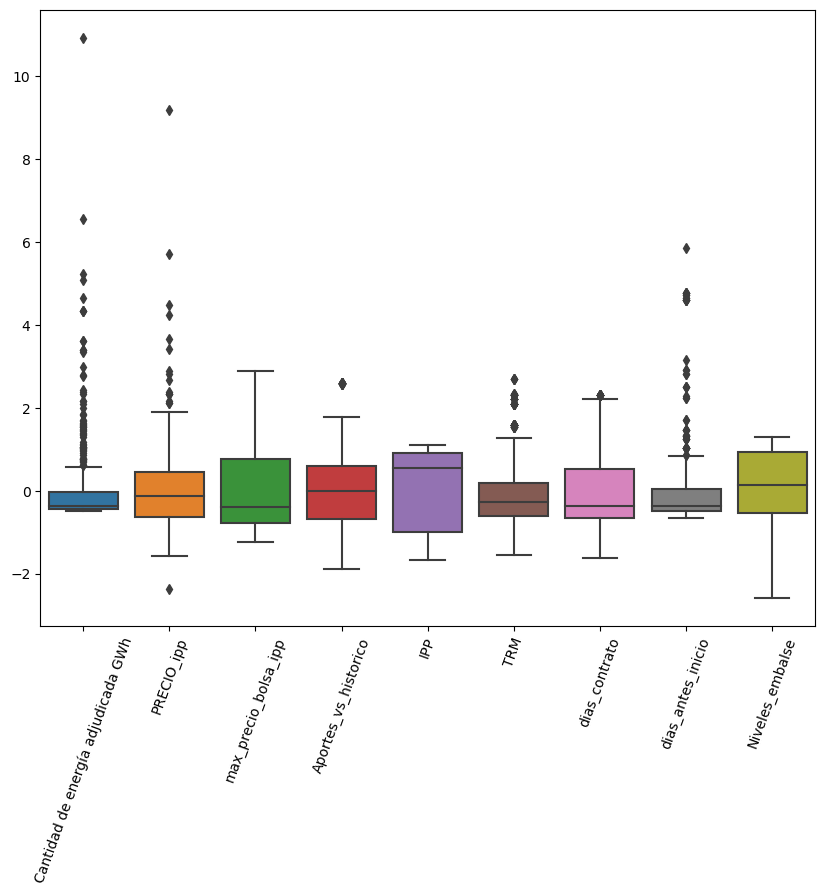

In [26]:
import seaborn as sns

from sklearn.preprocessing import StandardScaler

# Crea un objeto StandardScaler y ajusta los datos

df_correlacion = df[["Cantidad de energía adjudicada GWh","PRECIO_ipp", 'max_precio_bolsa_ipp',
                'Aportes_vs_historico', 'IPP', 'TRM',"dias_contrato","dias_antes_inicio","Niveles_embalse"]]
df_correlacion = df_correlacion.loc[:, ~df_correlacion.columns.duplicated()]

scaler = StandardScaler()
df_norm = pd.DataFrame(scaler.fit_transform(df_correlacion), columns=df_correlacion.columns)

# Crea una figura con un tamaño de 10x8 pulgadas
plt.figure(figsize=(10, 8))

# Crea un diagrama de caja para cada variable de la matriz de correlación
sns.boxplot(data=df_norm)

# Rota las etiquetas del eje x
plt.xticks(rotation=70)

# Muestra el gráfico
plt.show()



       Aportes_vs_historico
count            542.000000
mean               0.993843
std                0.284706
min                0.455753
25%                0.799611
50%                0.993427
75%                1.160742
max                1.730412


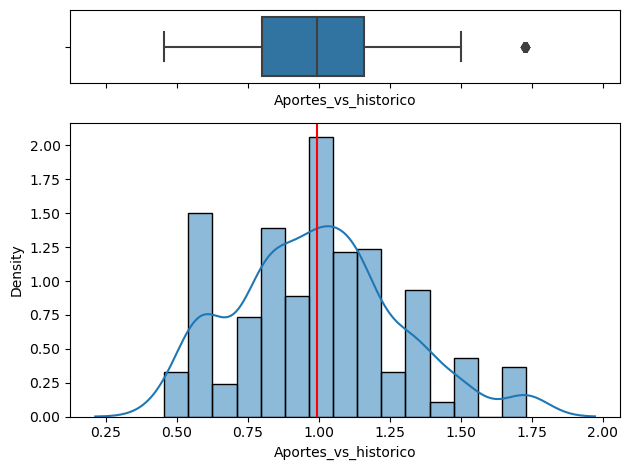

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

columna = 'Aportes_vs_historico'
# Descripción estadística en forma de tabla
description = df[columna].describe()
table = pd.DataFrame(description)
table.columns = ['Aportes_vs_historico']
print(table)

mask = df['dias_contrato']  # Columna df.fncer como máscara

x = df[columna]

f, ax = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.20, .80)})

sns.boxplot(x=x,  orient='h', ax=ax[0])
sns.histplot(data=df, x=columna,multiple="stack", kde=True, stat="density", kde_kws=dict(cut=3), ax=ax[1])
ax[1].axvline(x.mean(), color='red')

plt.xlabel(columna)

plt.tight_layout()
plt.show()



## modelos de regresion

In [28]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.linear_model import ElasticNet
import matplotlib.pyplot as plt


def funcion_grafica_principales(X,y,model,param_grid,titulo, xgboost = True):
    """ Funcion que busca hiperparametros y grafica importancia de las variables"""
    
    # Redirigir la salida estándar a un objeto "devnull"
    #os.devnull = open(os.devnull, 'w')
    
    # Realizar la búsqueda de hiperparámetros utilizando GridSearchCV
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X, y)

    # Obtener el mejor modelo y los mejores parámetros
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    print("Mejores parámetros encontrados:", best_params)

    # Calcular el MSE utilizando validación cruzada con el mejor modelo
    mse_scores = -cross_val_score(best_model, X, y, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

    # Calcular el MSE promedio
    mse_mean = np.mean(mse_scores)

    print("MSE utilizando validación cruzada:", mse_mean)

    # Entrenar el mejor modelo con todos los datos
    best_model.fit(X, y)

    if xgboost == True :
    # Obtener la importancia de las características
        importance = best_model.feature_importances_
    else:
        importance = best_model.coef_


    # Obtener los nombres de las características
    feature_names = X.columns

    # Ordenar las importancias de mayor a menor
    sorted_indices = np.argsort(importance)[::-1]
    sorted_importance = importance[sorted_indices]
    sorted_feature_names = feature_names[sorted_indices]

    # Crear un gráfico de barras para visualizar la importancia de las características ordenadas
    plt.figure(figsize=(10, 6))
    plt.barh(sorted_feature_names, sorted_importance)
    plt.xlabel('Importancia')
    plt.ylabel('Variable')
    plt.title(titulo)
    plt.show()

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

def funcion_grafica_principales(X,y,model,param_grid,titulo, xgboost = True):
    """ Funcion que busca hiperparametros y grafica importancia de las variables"""
    
    # Redirigir la salida estándar a un objeto "devnull"
    #os.devnull = open(os.devnull, 'w')
    
    # Realizar la búsqueda de hiperparámetros utilizando GridSearchCV
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X, y)

    # Obtener el mejor modelo y los mejores parámetros
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    print("Mejores parámetros encontrados:", best_params)

    # Calcular el MSE utilizando validación cruzada con el mejor modelo
    mse_scores = -cross_val_score(best_model, X, y, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    r2_scores = cross_val_score(best_model, X, y, cv=5, scoring='r2', n_jobs=-1)

    # Calcular el MSE promedio
    mse_mean = np.mean(mse_scores)
    r2_mean = np.mean(r2_scores)

    print("MSE utilizando validación cruzada:", mse_mean)
    print("R2 utilizando validación cruzada:", r2_mean)

    # Entrenar el mejor modelo con todos los datos
    best_model.fit(X, y)

    if xgboost == True :
    # Obtener la importancia de las características
        importance = best_model.feature_importances_
    else:
        importance = best_model.coef_


    # Obtener los nombres de las características
    feature_names = X.columns

    # Ordenar las importancias de mayor a menor
    sorted_indices = np.argsort(importance)[::-1]
    sorted_importance = importance[sorted_indices]
    sorted_feature_names = feature_names[sorted_indices]

    # Crear un gráfico de barras para visualizar la importancia de las características ordenadas
    plt.figure(figsize=(10, 6))
    plt.barh(sorted_feature_names, sorted_importance)
    plt.xlabel('Importancia')
    plt.ylabel('Variable')
    plt.title(titulo)
    plt.show()



In [30]:
##caso 1. con precio de la subasta y todas las variables
df_caso1 = df[['Precio promedio ponderado adjudicado ($/KWh)',"Cantidad de energía adjudicada GWh", 'max_precio_bolsa_ipp',
                'Aportes_vs_historico', 'IPP', 'TRM',"dias_contrato","dias_antes_inicio","Niveles_embalse"]]


# Obtener los datos de entrada X y la variable objetivo y
X1 = df_caso1.drop("Precio promedio ponderado adjudicado ($/KWh)", axis=1)
X1 = X1.loc[:, ~X1.columns.duplicated()]
y1 = df_caso1["Precio promedio ponderado adjudicado ($/KWh)"]



In [31]:
## caso 2 con precio dividido por el IPP y todas las variables
#definimos las variables a utilizar
df_caso2 = df[["Cantidad de energía adjudicada GWh","PRECIO_ipp", 'max_precio_bolsa_ipp',
                'Aportes_vs_historico', 'IPP', 'TRM',"dias_contrato","dias_antes_inicio","Niveles_embalse"]]


# Obtener los datos de entrada X y la variable objetivo y
X2 = df_caso2.drop("PRECIO_ipp", axis=1)
X2 = X2.loc[:, ~X2.columns.duplicated()]
y2 = df_caso2["PRECIO_ipp"]

In [32]:
## caso 3 con precio dividido por el IPP y  las variables propias del contrato
#definimos las variables a utilizar
df_caso3 = df[["Cantidad de energía adjudicada GWh","PRECIO_ipp"
                  ,"dias_contrato","dias_antes_inicio","energia_por_dia"]]

# Obtener los datos de entrada X y la variable objetivo y
X3 = df_caso3.drop("PRECIO_ipp", axis=1)
X3 = X3.loc[:, ~X3.columns.duplicated()]
y3 = df_caso3["PRECIO_ipp"]


In [33]:
import os
os.environ["PATH"] += os.pathsep + 'D:\\Graphviz\\bin'  # Ruta de Graphviz en tu sistema

# Luego, continúa con el código para generar el gráfico del árbol de decisión
os.getcwd()

'd:\\OneDrive\\Documents\\GitHub\\Analisis_impacto_obligacion_FNCER'

### XGBREGRESSOR

Caso 1

Mejores parámetros encontrados: {'learning_rate': 0.01, 'max_depth': 12, 'n_estimators': 500}
MSE utilizando validación cruzada: 1470.7881746894386
R2 utilizando validación cruzada: -0.2764671660243755


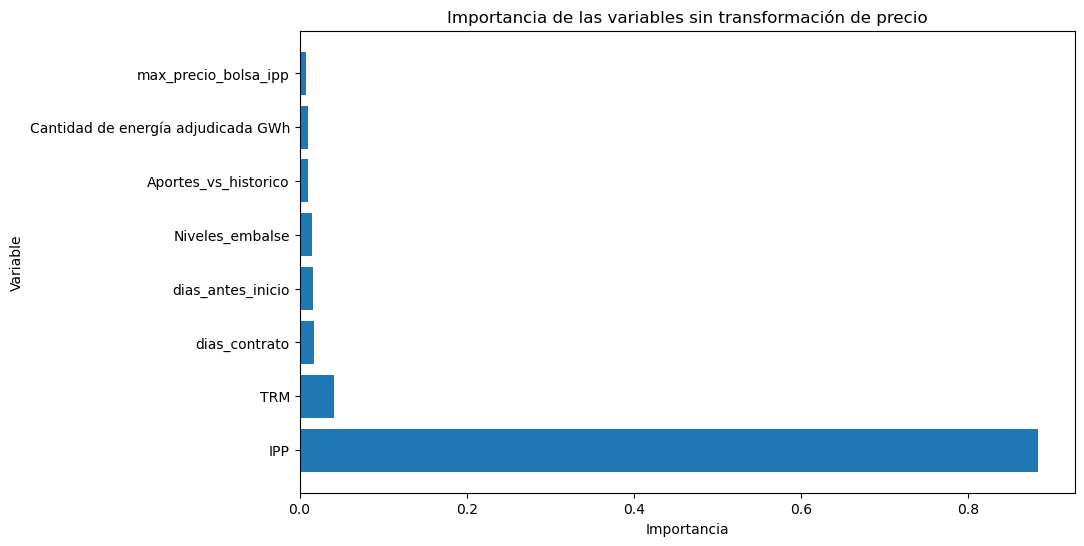

In [34]:
# Crear el modelo XGBoost
model = XGBRegressor(random_state=42)

# Definir los hiperparámetros a tunear
param_grid = {'n_estimators': [100, 500, 1000],
              'learning_rate': [0.1, 0.01, 0.001],
              'max_depth': [3, 5, 7, 10, 12]}

#Definimos nombre de la grafica
titulo = 'Importancia de las variables sin transformación de precio'

#aplicamos la funcion
funcion_grafica_principales(X1,y1,model,param_grid,titulo)

Caso 2

Mejores parámetros encontrados: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100}
MSE utilizando validación cruzada: 0.04999405697160476
R2 utilizando validación cruzada: -0.29540421990368443


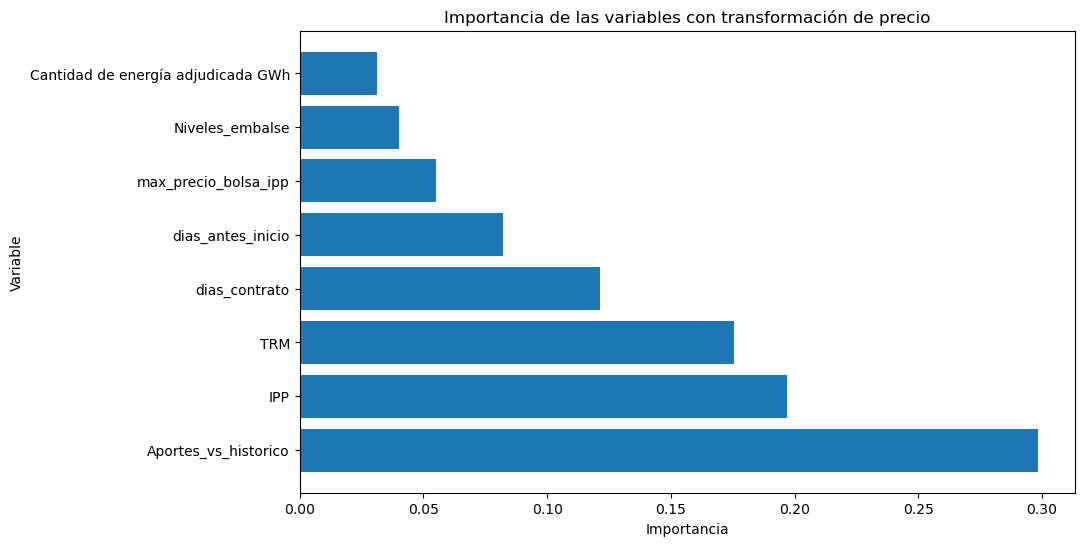

In [35]:
#Definimos nombre de la grafica
titulo = 'Importancia de las variables con transformación de precio'
param_grid = {'n_estimators': [100, 500, 1000],
              'learning_rate': [0.1, 0.01, 0.001, 0.0007],
              'max_depth': [3, 5, 7, 10, 12]}
#aplicamos la funcion
funcion_grafica_principales(X2,y2,model,param_grid,titulo)

Caso 3

Mejores parámetros encontrados: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500}
MSE utilizando validación cruzada: 0.06795346674877953
R2 utilizando validación cruzada: -0.7893407249768949


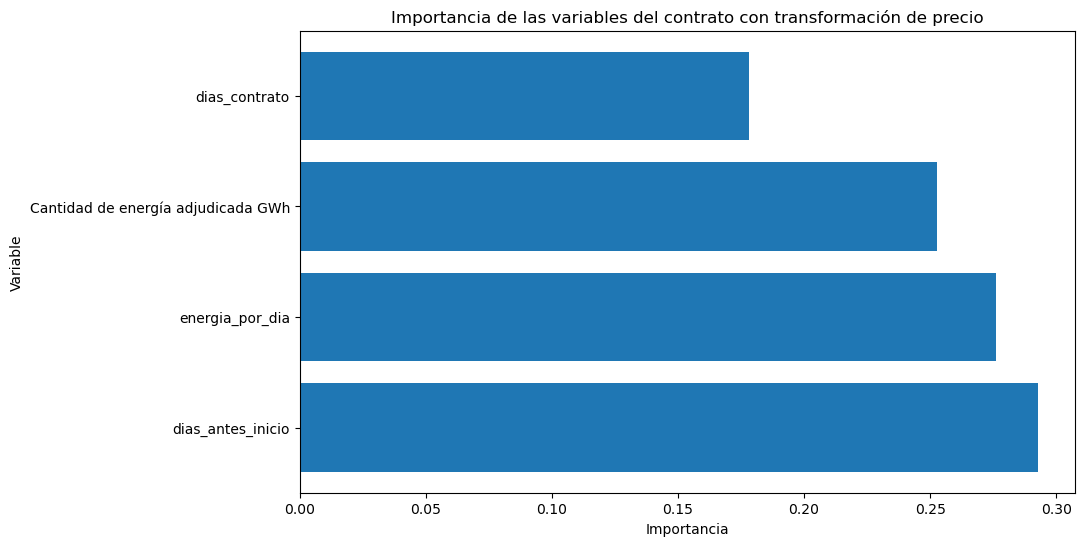

In [36]:
#Definimos nombre de la grafica
titulo = 'Importancia de las variables del contrato con transformación de precio'

#aplicamos la funcion
funcion_grafica_principales(X3,y3,model,param_grid,titulo)


### Regresion lineal con regularizacion

caso 1

Mejores parámetros encontrados: {'alpha': 0.1, 'l1_ratio': 1}
MSE utilizando validación cruzada: 1580.2843235153546
R2 utilizando validación cruzada: -0.8711052762712808


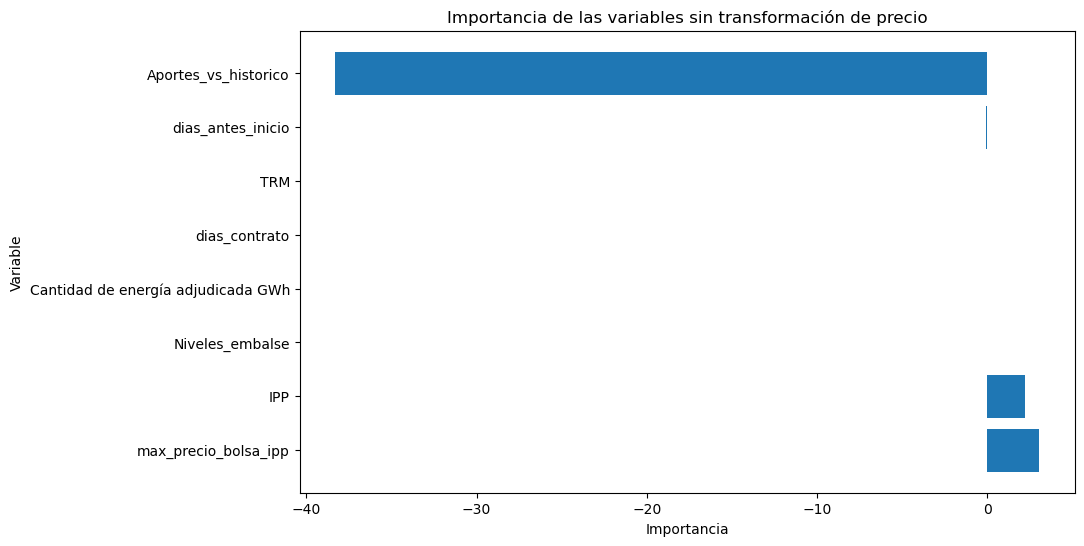

In [37]:
import warnings

# Ignorar los mensajes de advertencia
warnings.filterwarnings('ignore')

# Crear el modelo ElasticNet
model = ElasticNet(random_state=42)

# Definir los hiperparámetros a tunear
param_grid = {'alpha': [0.001,0.01,0.1, 1.0, 10.0],
              'l1_ratio': [0, 0.1, 0.5, 0.9, 1]}

#Definimos nombre de la grafica
titulo = 'Importancia de las variables sin transformación de precio'

#aplicamos la funcion
funcion_grafica_principales(X1,y1,model,param_grid,titulo, xgboost= False)

# Restaurar el comportamiento normal de las advertencias
warnings.filterwarnings('default')

Caso 2

Mejores parámetros encontrados: {'alpha': 0.001, 'l1_ratio': 1}
MSE utilizando validación cruzada: 0.054711931174333595
R2 utilizando validación cruzada: -0.672779436526761


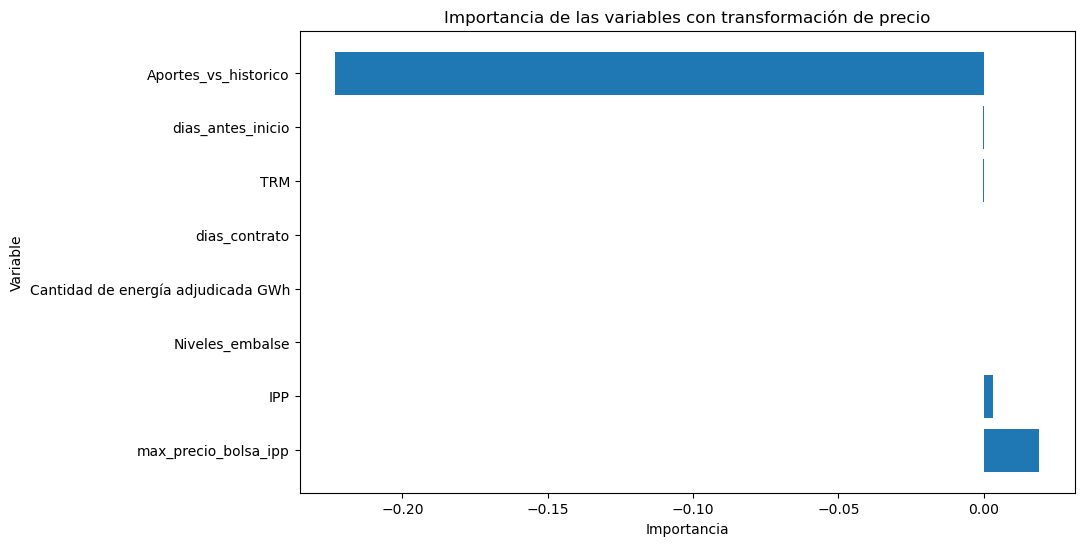

In [38]:
# Ignorar los mensajes de advertencia
warnings.filterwarnings('ignore')

#Definimos nombre de la grafica
titulo = 'Importancia de las variables con transformación de precio'

#aplicamos la funcion
funcion_grafica_principales(X2,y2,model,param_grid,titulo, xgboost= False)

# Restaurar el comportamiento normal de las advertencias
warnings.filterwarnings('default')

Caso 3

Mejores parámetros encontrados: {'alpha': 0.01, 'l1_ratio': 0}
MSE utilizando validación cruzada: 0.06390111514124133
R2 utilizando validación cruzada: -0.6921165418215011


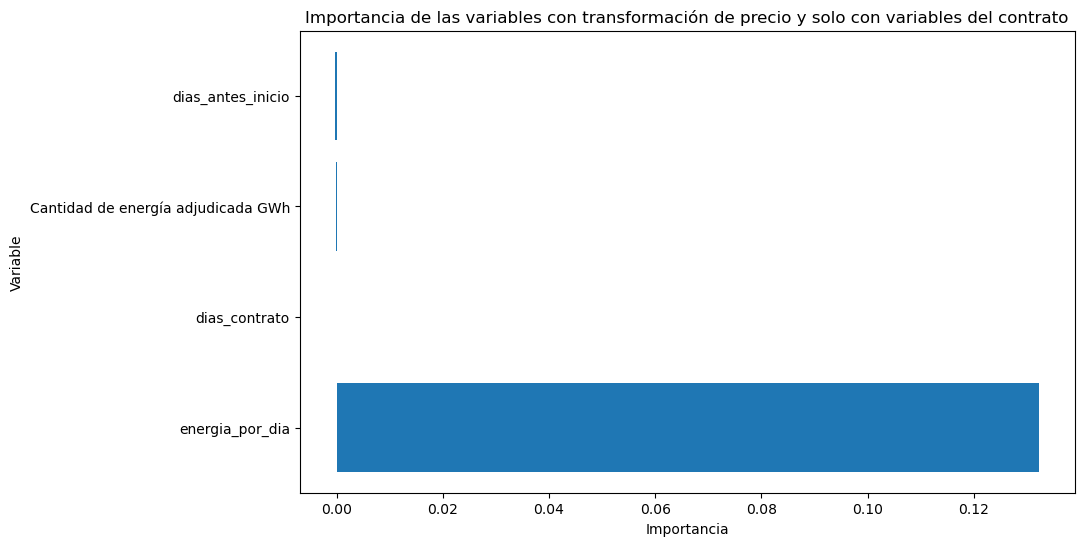

In [39]:
# Ignorar los mensajes de advertencia
warnings.filterwarnings('ignore')

#Definimos nombre de la grafica
titulo = 'Importancia de las variables con transformación de precio y solo con variables del contrato'

#aplicamos la funcion
funcion_grafica_principales(X3,y3,model,param_grid,titulo, xgboost= False)

# Restaurar el comportamiento normal de las advertencias
warnings.filterwarnings('default')

### SVM

Caso 1

In [46]:
from sklearn.svm import SVR
# Crear el modelo ElasticNet
model = SVR()

# Definir los hiperparámetros a tunear
param_grid = {'kernel': ['linear', 'poly', 'rbf'],
              'C': [0.1, 1, 10]}
              #'gamma': ['scale', 'auto']}

#Definimos nombre de la grafica
titulo = 'Importancia de las variables sin transformación de precio'

#aplicamos la funcion
funcion_grafica_principales(X2,y2,model,param_grid,titulo)


Mejores parámetros encontrados: {'C': 1, 'kernel': 'poly'}
MSE utilizando validación cruzada: 0.06167134851194932
R2 utilizando validación cruzada: -0.5053518289019018


AttributeError: 'SVR' object has no attribute 'feature_importances_'

Caso 2

In [41]:
"""
#Definimos nombre de la grafica
titulo = 'Importancia de las variables con transformación de precio'
#aplicamos la funcion
funcion_grafica_principales(X2,y2,model,param_grid,titulo)
"""

"\n#Definimos nombre de la grafica\ntitulo = 'Importancia de las variables con transformación de precio'\n#aplicamos la funcion\nfuncion_grafica_principales(X2,y2,model,param_grid,titulo)\n"

Caso 3

In [42]:
"""
#Definimos nombre de la grafica
titulo = 'Importancia de las variables con transformación de precio y solo con variables del contrato'

#aplicamos la funcion
funcion_grafica_principales(X3,y3,model,param_grid,titulo)
"""

"\n#Definimos nombre de la grafica\ntitulo = 'Importancia de las variables con transformación de precio y solo con variables del contrato'\n\n#aplicamos la funcion\nfuncion_grafica_principales(X3,y3,model,param_grid,titulo)\n"

### RandomForestRegressor

Caso 1

Mejores parámetros encontrados: {'max_depth': 3, 'n_estimators': 1000}
MSE utilizando validación cruzada: 1483.583346025243
R2 utilizando validación cruzada: -0.32097661043454084


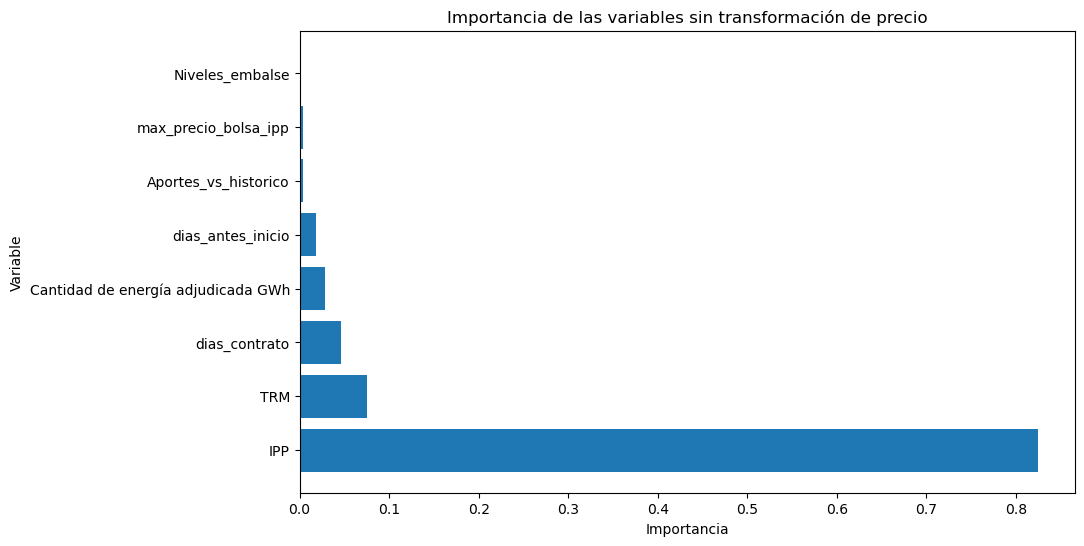

In [43]:
from sklearn.ensemble import RandomForestRegressor

# Crear el modelo RandomForestRegressor
model = RandomForestRegressor(random_state=42)

# Definir los hiperparámetros a tunear
param_grid = {'n_estimators': [100, 500, 1000],
              'max_depth': [3, 5, 7]}

#Definimos nombre de la grafica
titulo = 'Importancia de las variables sin transformación de precio'

#aplicamos la funcion
funcion_grafica_principales(X1,y1,model,param_grid,titulo)

Caso 2

Mejores parámetros encontrados: {'max_depth': 9, 'n_estimators': 100}
MSE utilizando validación cruzada: 0.051405513420026284
R2 utilizando validación cruzada: -0.27707602258006203


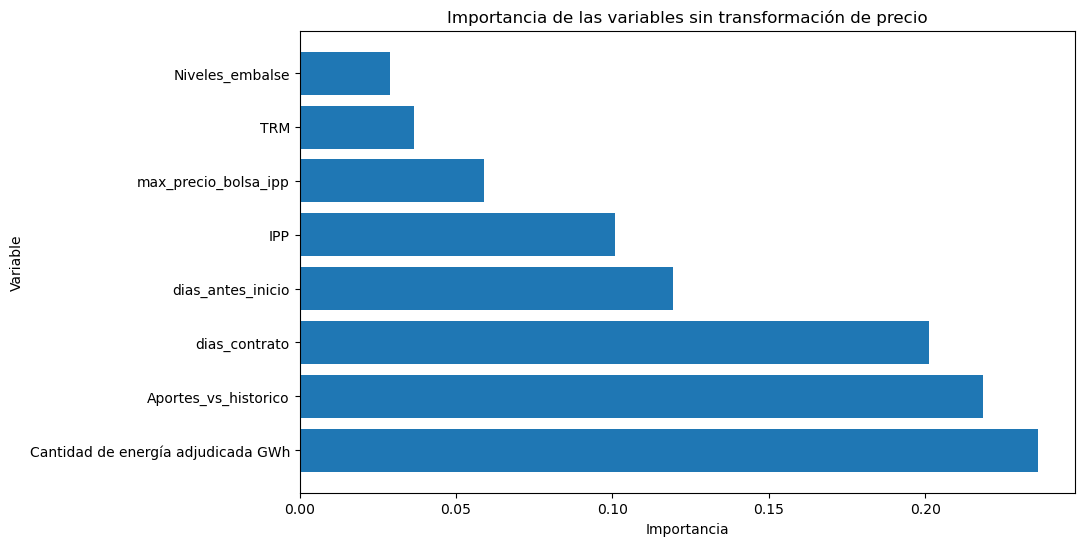

In [44]:
#Definimos nombre de la grafica
titulo = 'Importancia de las variables sin transformación de precio'
param_grid = {'n_estimators': [50, 100, 500, 1000],
              'max_depth': [5, 7, 9, 15]}
#aplicamos la funcion
funcion_grafica_principales(X2,y2,model,param_grid,titulo)

Caso 3

Mejores parámetros encontrados: {'max_depth': 5, 'n_estimators': 1000}
MSE utilizando validación cruzada: 0.06947383713549835
R2 utilizando validación cruzada: -0.8434013016765973


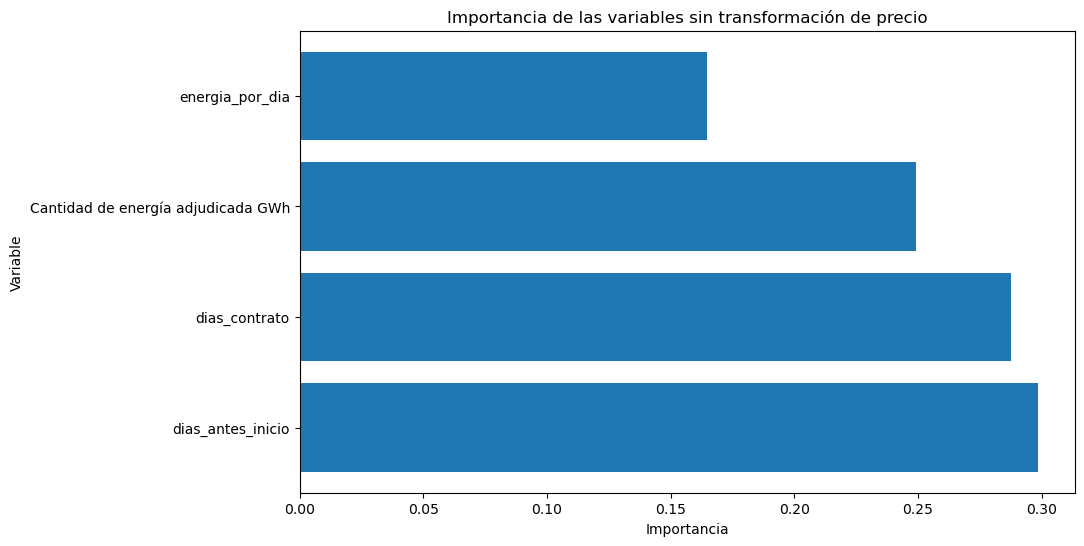

In [45]:
#Definimos nombre de la grafica
titulo = 'Importancia de las variables sin transformación de precio'

#aplicamos la funcion
funcion_grafica_principales(X3,y3,model,param_grid,titulo)